#Installations, Imports, and Utils

In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install -U moviepy==0.2.3.5
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
!AutoROM --accept-license
!pip install gym[classic_control] > /dev/null 2>&1
!pip install pettingzoo
!pip install swig
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3130 sha256=d7a0307740956b6b629de12e8bb1d53030ba382ec676acd8ba82dcacd604d9b6
  Stored in directory: /root/.cache/pip/wheels/13/62/63/7b3acfb684dd3d665d7fc1d213427b136205a222389767e295
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.0/373.0 kB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for moviepy: filename=moviepy-0.2.3.5-py3-none-any.whl size=130215 sha256=234c8ac7060edfa165104e4ca75a065e26dbcb31847ada04718e3cc092b0c0be
  Stored in directory: /root/.cache/pip/wheels/7c/a0/a9/112e9a44d5b0e5d07d434bd0b8b1bfc8efdf8e305c3332febb
Successfully built moviepy
  Attempting uninstall: moviepy
    Found ex

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from colabgymrender.recorder import Recorder
import random
import matplotlib.pyplot as plt
from pettingzoo.mpe import simple_spread_v2
from IPython.core.display import Video, display
from moviepy.editor import *
import time
import cv2
import os

# Setting the seed to ensure reproducability
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

directory = './video'

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Error while fetching file: The read operation timed out.
Try 2. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3072000/45929032 bytes (6.7%)5947392/45929032 bytes (12.9%)8642560/45929032 bytes (18.8%)11452416/45929032 bytes (24.9%)13729792/45929032 bytes (29.9%)16449536/45929032 bytes (35.8%)19210240/45929032 bytes (41.8%)21135360/45929032 bytes (46.0%)24780800/45929032 bytes (54.0%)28147712/45929032 bytes (61.3%)30949376/45929032 bytes (67.4%)3418

  from scipy.ndimage.filters import sobel



The next two code sections implement the policy/actor network and value/critic network respectively.

In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int):
        """Policy network for the REINFORCE algorithm.

        Args:
            state_dim (int): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            hidden_dim (int): Dimension of the hidden layers.
        """
        super(PolicyNet, self).__init__()
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, action_dim)
        self.softmax = nn.Softmax()

    def forward(self, state: torch.Tensor):
        """Forward pass of the policy network.

        Args:
            state (torch.Tensor): State of the environment.

        Returns:
            x (torch.Tensor): Probabilities of the actions.
        """
        hidden = self.relu(self.linear1(state))
        x = self.softmax(self.linear2(hidden))
        return x

  and should_run_async(code)



In [ ]:
class ValueNet(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int):
        """Value network for the Actor-Critic algorithm.

        Args:
            state_dim (int): Dimension of the state space.
            hidden_dim (int): Dimension of the hidden layers.
        """
        super(ValueNet, self).__init__()
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor):
        """Forward pass of the value network.

        Args:
            state (torch.Tensor): State of the environment.

        Returns:
            x (torch.Tensor): Estimated value of the state.
        """
        hidden = self.relu(self.linear1(state))
        x = self.linear2(hidden)
        return x

In [ ]:
#Utility function for creating a plot
def create_graph(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.title('{}: {} .vs. {}'.format(title, xlabel, ylabel))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Single Agent PPO on CartPole Environment

The next code section defines the PPO model to train on CartPole.

In [ ]:
class ActorCriticPolicyGradient():
    def __init__(self, env, new_actor: PolicyNet, old_actor: PolicyNet, value_net: ValueNet):
        """Actor-Critic policy gradient algorithm.

        Args:
            env (gym.Env): Environment
            actor1 (PolicyNet): Policy network
            value_net (ValueNet): Value network
        """
        self.env = Recorder(env, directory)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.new_actor = new_actor.to(self.device)
        self.old_actor= old_actor.to(self.device)
        self.value_net = value_net.to(self.device)

    def _clip(self, val, min_val, max_val):
      """Implements the clip function

        Args:
            val : value to be clipped
            min_val : minimum value
            max_val : maximum value

        Returns:
            val : clipped value within the bounds
      """
      if val < min_val: return min_val
      if val > max_val: return max_val
      return val

    def compute_policy_loss(self,episode,advantages,gamma=0.99,epsilon=0.2):
      """Compute the policy loss function

        Args:
            episode (list): List of tuples (state, action, reward)
            advantages (list): List of advantages
            gamma (float): Discount factor
            epsilon (flota): Clipping factor

        Returns:
            policy_loss (float): Policy loss function
        """
      policy_loss=0
      for i in range(len(episode)):
            state, action, _ = episode[i]
            new_action_probs = self.new_actor(torch.from_numpy(state).to(self.device))
            old_action_probs= self.old_actor(torch.from_numpy(state).to(self.device))
            ratio=new_action_probs[action]/old_action_probs[action]
            clipped_ratio=self._clip(ratio,1-epsilon,1+epsilon)
            policy_loss -= min(ratio*advantages[i],clipped_ratio*advantages[i])
      return policy_loss

    def loss_pre_processing(self, episode, gamma = 0.99):
      """Compute the loss function for the ValueNet and the advantages for an
          episode

        Args:
            episode (list): List of tuples (state, action, reward)
            gamma (float): Discount factor

        Returns:
            value_loss (float): Value loss function
            advantages (list): List of advantages
      """
      rewards = []
      values = []
      advantages=[]
      states=[]
      actions=[]

      # Extract rewards and values
      for i in range(len(episode)):
            state, _, reward = episode[i]
            rewards.append(reward)
            value = self.value_net(torch.from_numpy(state).to(self.device))
            values.append(value)
      
      #Calculate MSE loss + advantages
      value_loss=0
      for i in range(len(episode)):
            q_t = 0
            for j in range(i, len(episode)):
                q_t += rewards[j] * (gamma ** j)
            advantages.append(q_t-values[i])
            value_loss += (1 / 2) * ((values[i] - q_t) ** 2)
      return value_loss, advantages

    def update_policy(self, episodes, policy_optimizer, value_optimizer, epochs, gamma=0.99, epsilon=0.2):
        """Update the policy network and value network using the batch of episodes

        Args:
            episodes (list): List of episodes
            policy_optimizer (torch.optim): Optimizer for the policy network
            value_optimizer (torch.optim): Optimizer for the value network
            epochs (int): Number of epochs to update new actor per iteration
            gamma (float): Discount factor
            epsilon (float): Clipping factor
        """
        
        #Compute total value loss and advantages for each timestep
        #in each episode
        value_losses = 0
        episode_advantages=[]
        for i in range(len(episodes)):
          value_loss,advantages=self.loss_pre_processing(episodes[i],gamma)
          episode_advantages.append(advantages)
          value_losses += (1 / len(episodes)) * value_loss
        
        #Optimize policy/actor network for k epochs
        for k in range(epochs):
          policy_losses=0
          for i in range(len(episodes)):
            policy_loss = self.compute_policy_loss(episodes[i], episode_advantages[i], gamma, epsilon)
            policy_losses += (1 / len(episodes)) * policy_loss
          policy_optimizer.zero_grad()
          policy_losses.backward(retain_graph=True)
          policy_optimizer.step()

        #optimize value/critic net
        value_optimizer.zero_grad()
        value_losses.backward()
        value_optimizer.step()
        self.old_actor.load_state_dict(self.new_actor.state_dict())

    def select_action(self, state, net):
      """Select an action based on the policy network

      Args:
          state (np.ndarray): State of the environment
          net: Neural network to use

      Returns:
          action (int): Action to be taken
      """
      action_probs = net(torch.from_numpy(state).to(self.device))
      action_dist = torch.distributions.Categorical(action_probs)
      action = action_dist.sample()
      return int(action)
    
    def run_episode(self,net, render = False):
        """
        Run an episode of the environment and return the episode
        
        Returns:
            episode (list): List of tuples (state, action, reward)
        """
        state = self.env.reset()
        episode = []
        done = False
        while not done:
            action = self.select_action(state, net)
            next_state, reward, done, info = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        if render:
          self.env.play()
        return episode

    def evaluate(self, net, num_episodes = 100, max_steps = 1000):
        """Evaluate the policy network by running multiple episodes.

        Args:
            num_episodes (int): Number of episodes to run
            max_steps (int): Maximum number of steps in the episode
        Returns:
            average_reward (float): Average reward over the episodes
        """
        total_reward = 0
        for i in range(num_episodes):
            episode = self.run_episode(net)
            cur_reward = 0
            for j in range(min(len(episode), max_steps)):
                cur_reward += episode[j][2]
            total_reward += cur_reward
        average_reward = total_reward / num_episodes
        return average_reward

    def train(self, num_outer_loop, num_episodes, epochs, gamma=0.99, epsilon=0.2, lr=0.01):
        """Train the policy network using the REINFORCE algorithm

        Args:
            num_outer_loop (int): Number of outerloops i.e. iterations, i.e., calls to update_policy
            num_episodes (int): Number of episodes to collect in each iteration
            gamma (float): Discount factor
            lr (float): Learning rate
        """
        policy_optimizer = optim.Adam(self.new_actor.parameters(), lr=lr)
        value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr)
        rewards = []
        for i in range(num_outer_loop):
            print('Iteration {}'.format(str(i)))
            episodes = []
            for j in range(num_episodes):
                episodes.append(self.run_episode(self.old_actor))
            self.update_policy(episodes, policy_optimizer, value_optimizer, epochs, gamma=gamma,epsilon=epsilon)
            if (i%10==0):
              rewards.append(self.evaluate(self.new_actor, num_episodes=10))
        create_graph(np.arange(0,num_outer_loop,10), rewards, 'Training iterations', 'Rewards', 'Actor-Critic')

The next code sections train and evaluate the PPO model's performance on the CartPole environment.

  logger.warn(

  deprecation(

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  x = self.softmax(self.linear2(hidden))



Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

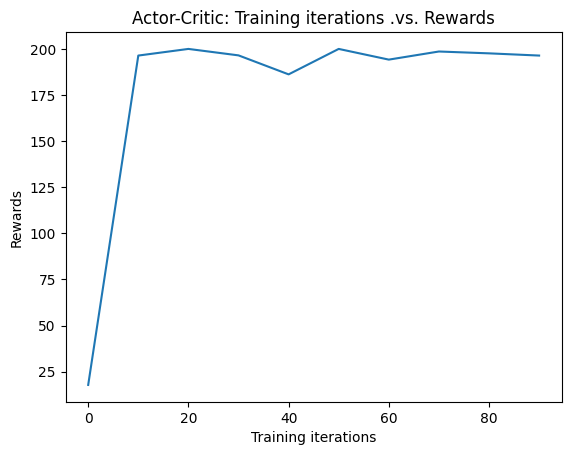

In [ ]:
#First test of PPO
env = gym.make("CartPole-v0")
env.seed(0)
env.action_space.seed(0)
## TODO: Construct the policy network, value networks and the policy gradient algorithm here and train the policy network and value networks
## We recommend using gamma at 0.99, lr to be around 0.01, num_outer_loop to be around 100 iterations and num_episodes to be around 10 episodes per iteration as a starting point
## We also recommend using an Adam Optimizer for the policy and value net
gamma = 0.99
lr = 0.01
num_outer_loop = 100
num_episodes = 10
epochs=10
epsilon=0.2

state_dim = 4
action_dim = 2
hidden_dim = 128

old_actor = PolicyNet(state_dim, action_dim, hidden_dim)
new_actor = PolicyNet(state_dim, action_dim, hidden_dim)
new_actor.load_state_dict(old_actor.state_dict())
value_net = ValueNet(state_dim, hidden_dim)

actor_gradient = ActorCriticPolicyGradient(env, new_actor,old_actor, value_net)
actor_gradient.train(num_outer_loop, num_episodes,epochs, gamma=gamma, epsilon=epsilon, lr=lr)

In [ ]:
actor_gradient.evaluate(new_actor, num_episodes=100)

  x = self.softmax(self.linear2(hidden))



195.63

In [ ]:
actor_gradient.run_episode(new_actor,render=True)

  and should_run_async(code)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  x = self.softmax(self.linear2(hidden))

  result = np.fromstring(s, dtype='uint8')



[(array([ 0.025923  ,  0.02037169, -0.02265751, -0.04603368], dtype=float32),
  0,
  1.0),
 (array([ 0.02633043, -0.17441817, -0.02357818,  0.23941536], dtype=float32),
  1,
  1.0),
 (array([ 0.02284207,  0.02103254, -0.01878987, -0.06061055], dtype=float32),
  0,
  1.0),
 (array([ 0.02326272, -0.17381503, -0.02000208,  0.22608532], dtype=float32),
  1,
  1.0),
 (array([ 0.01978642,  0.02158699, -0.01548038, -0.07283929], dtype=float32),
  0,
  1.0),
 (array([ 0.02021816, -0.17330965, -0.01693716,  0.21491958], dtype=float32),
  1,
  1.0),
 (array([ 0.01675197,  0.02205029, -0.01263877, -0.08305759], dtype=float32),
  0,
  1.0),
 (array([ 0.01719297, -0.17288822, -0.01429992,  0.20561114], dtype=float32),
  1,
  1.0),
 (array([ 0.01373521,  0.02243527, -0.0101877 , -0.09154818], dtype=float32),
  0,
  1.0),
 (array([ 0.01418391, -0.17253919, -0.01201866,  0.1979032 ], dtype=float32),
  1,
  1.0),
 (array([ 0.01073313,  0.02275259, -0.0080606 , -0.09854671], dtype=float32),
  0,
  1.0),

# Multi-Agent PPO on Simple Spread Environment (Trained from Scratch)

In [ ]:
class MAPPO_Recorder():
    def __init__(self, env, new_actor: PolicyNet, old_actor: PolicyNet, value_net: ValueNet, directory=None):
        """Actor-Critic policy gradient algorithm.

        Args:
            env (gym.Env): Environment
            actor1 (PolicyNet): Policy network
            value_net (ValueNet): Value network
        """
        self.env = env
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.new_actor = new_actor.to(self.device)
        self.old_actor= old_actor.to(self.device)
        self.value_net = value_net.to(self.device)
        
###############################################################################
#Recording stuff
#Code for recording adapted from: https://github.com/ryanrudes/renderlab/blob/main/renderlab/render_frame.py

        self.env.reset()
        self.size = self.env.render().shape[:2][::-1]
        self.directory=directory
        self.fps=10 #based on simple spread environment
        self.active=True
        self.rgb=True

        if directory is not None and not os.path.exists(self.directory):
            os.mkdir(self.directory)

    def _start(self):
        self.cliptime = time.time()
        self.path = f'{self.directory}/{self.cliptime}.mp4'
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        self._writer = cv2.VideoWriter(self.path, fourcc, self.fps, self.size)

    def _write(self):
        if self.active:
            frame = self.env.render()
            if self.rgb:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            self._writer.write(frame)

    def release(self):
        self._writer.release()

    def play(self):
      start = time.time()
      filename = 'temp-{start}.mp4'
      clip = VideoFileClip(self.path)
      clip.write_videofile(filename, progress_bar = False, verbose = False)
      display(Video(filename, embed = True))
      os.remove(filename)

################################################################################

    def _clip(self, val, min_val, max_val):
      """Implements the clip function

        Args:
            val : value to be clipped
            min_val : minimum value
            max_val : maximum value

        Returns:
            val : clipped value within the bounds
      """
      if val < min_val: return min_val
      if val > max_val: return max_val
      return val

    def compute_policy_loss(self,episode,advantages,gamma=0.99,epsilon=0.2):
      """Compute the policy loss function

        Args:
            episode (list): List of tuples (state, action, reward)
            advantages (list): List of advantages
            gamma (float): Discount factor
            epsilon (flota): Clipping factor

        Returns:
            policy_loss (float): Policy loss function
        """
      policy_loss=0
      for i in range(len(episode)):
            _, observation, action, _ = episode[i]
            new_action_probs = self.new_actor(torch.from_numpy(observation).to(self.device))
            old_action_probs= self.old_actor(torch.from_numpy(observation).to(self.device))
            ratio=new_action_probs[action]/old_action_probs[action]
            clipped_ratio=self._clip(ratio,1-epsilon,1+epsilon)
            policy_loss -= min(ratio*advantages[i],clipped_ratio*advantages[i])
      return policy_loss

    def loss_pre_processing(self, episode, gamma = 0.99):
      """Compute the loss function for the ValueNet and the advantages for an
          episode

        Args:
            episode (list): List of tuples (state, action, reward)
            gamma (float): Discount factor

        Returns:
            value_loss (float): Value loss function
            advantages (list): List of advantages
      """
      rewards = []
      values = []
      advantages=[]
      states=[]
      actions=[]

      # Extract rewards and values
      for i in range(len(episode)):
            state, _, _, reward = episode[i]
            rewards.append(reward)
            value = self.value_net(torch.from_numpy(state).to(self.device))
            values.append(value)
      
      #Calculate MSE loss + advantages
      value_loss=0
      for i in range(len(episode)):
            q_t = 0
            for j in range(i, len(episode)):
                q_t += rewards[j] * (gamma ** j)
            advantages.append(q_t-values[i])
            value_loss += (1 / 2) * ((values[i] - q_t) ** 2)
      return value_loss, advantages

    def update_policy(self, episodes, policy_optimizer, value_optimizer, epochs, gamma=0.99, epsilon=0.2):
        """Update the policy network and value network using the batch of episodes

        Args:
            episodes (list): List of episodes
            policy_optimizer (torch.optim): Optimizer for the policy network
            value_optimizer (torch.optim): Optimizer for the value network
            epochs (int): Number of epochs to update new actor per iteration
            gamma (float): Discount factor
            epsilon (float): Clipping factor
        """
        
        #Compute total value loss and advantages for each timestep
        #in each episode
        value_losses = 0
        episode_advantages=[]
        for i in range(len(episodes)):
          value_loss,advantages=self.loss_pre_processing(episodes[i],gamma)
          episode_advantages.append(advantages)
          value_losses += (1 / len(episodes)) * value_loss
        
        #Optimize policy/actor network for k epochs
        for k in range(epochs):
          policy_losses=0
          for i in range(len(episodes)):
            policy_loss = self.compute_policy_loss(episodes[i], episode_advantages[i], gamma, epsilon)
            policy_losses += (1 / len(episodes)) * policy_loss
          policy_optimizer.zero_grad()
          policy_losses.backward(retain_graph=True)
          policy_optimizer.step()

        #optimize value/critic net
        value_optimizer.zero_grad()
        value_losses.backward()
        value_optimizer.step()
        self.old_actor.load_state_dict(self.new_actor.state_dict())

    def select_action(self, state, net):
      """Select an action based on the policy network

      Args:
          state (np.ndarray): State of the environment
          net: Neural network to use

      Returns:
          action (int): Action to be taken
      """
      action_probs = net(torch.from_numpy(state).to(self.device))
      action_dist = torch.distributions.Categorical(action_probs)
      action = action_dist.sample()
      return int(action)
    

    def run_episode(self, net, render = False):
        """
        Run an episode of the environment and return the episode
        
        Returns:
            episode (list): List of tuples (global state, observation, action, reward)
        """
        self.env.reset(seed=0)
        
        if render:
          self._start()
          self._write()
        
        
        episode=[]
        for agent in self.env.agent_iter():
          observation, _, termination, truncation, _ = self.env.last()
          global_state=self.env.state()
          if termination or truncation:
            action=None
            self.env.step(action)
          else:
            action = self.select_action(observation, net)
            self.env.step(action)
            total_agent_rewards=0
            for reward in self.env.rewards.values():
              total_agent_rewards+=reward
            episode.append((global_state,observation,action,total_agent_rewards))
          if render:
            self._write()
             
        if render:
          self.release()
          self.play()
          return None
        else:
          return episode

    def evaluate(self, net, num_episodes = 100, max_steps = 1000):
        """Evaluate the policy network by running multiple episodes.

        Args:
            num_episodes (int): Number of episodes to run
            max_steps (int): Maximum number of steps in the episode
        Returns:
            average_reward (float): Average reward over the episodes
        """
        total_reward = 0
        for i in range(num_episodes):
            episode = self.run_episode(net)
            cur_reward = 0
            for j in range(min(len(episode), max_steps)):
                cur_reward += episode[j][3]
            total_reward += cur_reward
        average_reward = total_reward / num_episodes
        return average_reward

    def train(self, num_outer_loop, num_episodes, epochs, gamma=0.99, epsilon=0.2, lr=0.01):
        """Train the policy network using the REINFORCE algorithm

        Args:
            num_outer_loop (int): Number of outerloops i.e. iterations, i.e., calls to update_policy
            num_episodes (int): Number of episodes to collect in each iteration
            gamma (float): Discount factor
            lr (float): Learning rate
        """
        policy_optimizer = optim.Adam(self.new_actor.parameters(), lr=lr)
        value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr)
        rewards = []
        for i in range(num_outer_loop):
            print('Iteration {}'.format(str(i)))
            episodes = []
            for j in range(num_episodes):
                episodes.append(self.run_episode(self.old_actor))
            self.update_policy(episodes, policy_optimizer, value_optimizer, epochs, gamma=gamma,epsilon=epsilon)
            if (i%10==0):
              average_reward = self.evaluate(self.new_actor, num_episodes=10)
              print("Average Episode Reward: ", average_reward)
              rewards.append(average_reward)
        create_graph(np.arange(0,num_outer_loop,10), rewards, 'Training iterations', 'Rewards', 'MAPPO')

  x = self.softmax(self.linear2(hidden))



Iteration 0
Average Episode Reward:  -110.64916275596927
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Average Episode Reward:  -102.10382593941613
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Average Episode Reward:  -94.7956948023818
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Average Episode Reward:  -87.38970217997597
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Average Episode Reward:  -76.91053011373651
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Average Episode Reward:  -73.45811151633082
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iter

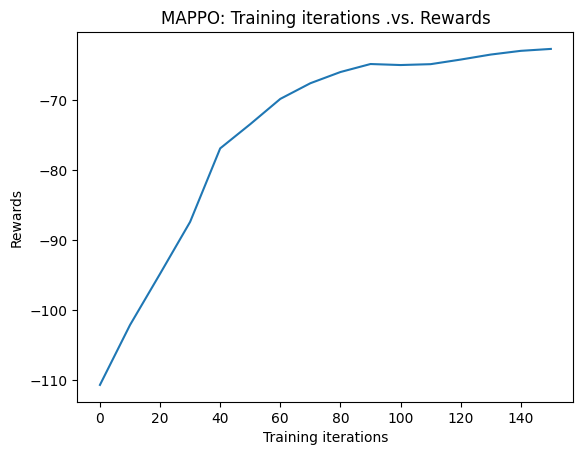

In [ ]:
env = simple_spread_v2.env(N=3, local_ratio=0.5, max_cycles=25, continuous_actions=False, render_mode='rgb_array')

gamma = 0.99
lr = 0.01
num_outer_loop = 151
num_episodes = 40
epochs=10
epsilon=0.2

action_state_dim = 18
value_state_dim=3*18
action_dim = 5
hidden_dim = 128


old_actor = PolicyNet(action_state_dim, action_dim, hidden_dim)
new_actor = PolicyNet(action_state_dim, action_dim, hidden_dim)
new_actor.load_state_dict(old_actor.state_dict())
value_net = ValueNet(value_state_dim, hidden_dim)
model = MAPPO_Recorder(env, new_actor, old_actor, value_net)
model.train(num_outer_loop, num_episodes, epochs, gamma, epsilon, lr)

In [ ]:
model.evaluate(model.new_actor, num_episodes=100)

  x = self.softmax(self.linear2(hidden))



-62.43781064866293

In [ ]:
#Random policy baseline
from pettingzoo.utils import average_total_reward
env = simple_spread_v2.env(N=3, local_ratio=0.5, max_cycles=25, continuous_actions=False, render_mode='rgb_array')
average_total_reward(env, max_episodes=100, max_steps=10000000000)
pass

Average total reward -117.0914157526919


#Single Agent PPO on Simple Environment

  x = self.softmax(self.linear2(hidden))



Iteration 0
Average Episode Reward:  -32.176241085368915
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Average Episode Reward:  -17.537013329894602
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Average Episode Reward:  -13.32038136029442
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Average Episode Reward:  -9.322204646777237
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Average Episode Reward:  -8.003040994682983
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Average Episode Reward:  -8.141806644270256
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Ite

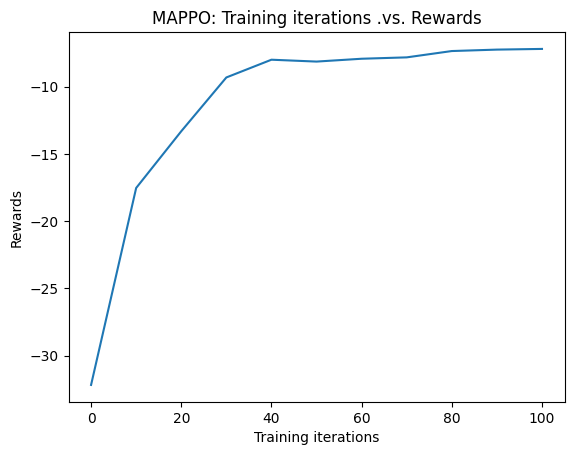

In [ ]:
from pettingzoo.mpe import simple_v2
env = simple_v2.env(max_cycles=25, continuous_actions=False, render_mode='rgb_array')

gamma = 0.99
lr = 0.01
num_outer_loop = 101
num_episodes = 10
epochs=10
epsilon=0.2

action_state_dim = 4
value_state_dim= 4
action_dim = 5
hidden_dim = 128


old_actor = PolicyNet(action_state_dim, action_dim, hidden_dim)
new_actor = PolicyNet(action_state_dim, action_dim, hidden_dim)
new_actor.load_state_dict(old_actor.state_dict())
value_net = ValueNet(value_state_dim, hidden_dim)
simple_model = MAPPO_Recorder(env, new_actor, old_actor, value_net)
simple_model.train(num_outer_loop, num_episodes, epochs, gamma, epsilon, lr)

In [ ]:
simple_model.evaluate(simple_model.new_actor, num_episodes=100)

  x = self.softmax(self.linear2(hidden))



-7.1969702632979

In [ ]:
#Random policy baseline
from pettingzoo.utils import average_total_reward
env = simple_v2.env(max_cycles=25, continuous_actions=False, render_mode='rgb_array')
average_total_reward(env, max_episodes=100, max_steps=10000000000)
pass

Average total reward -40.362919942515745


#Multi-Agent PPO on Simple Spread Environment (Trained using Model from Simple Environment)

  x = self.softmax(self.linear2(hidden))



Iteration 0
Average Episode Reward:  -109.0880067757166
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Average Episode Reward:  -88.49960313082181
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Average Episode Reward:  -84.195595051006
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Average Episode Reward:  -79.08707741472595
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Average Episode Reward:  -78.21278073703417
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Average Episode Reward:  -70.15515084326739
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iterati

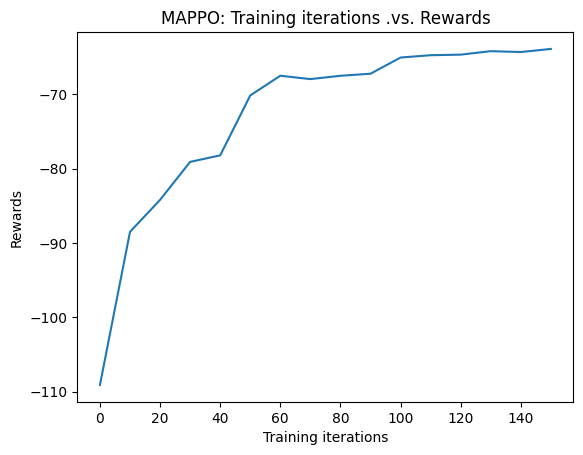

In [ ]:
#Attempt at transfer learning
#Code for custom transferring of state dicts was from this thread:
#https://github.com/pytorch/pytorch/issues/40859
env = simple_spread_v2.env(N=3, local_ratio=0.5, max_cycles=25, continuous_actions=False, render_mode='rgb_array')

gamma = 0.99
lr = 0.01
num_outer_loop = 151
num_episodes = 40
epochs=10
epsilon=0.2

action_state_dim = 18
value_state_dim=3*18
action_dim = 5
hidden_dim = 128

#Initialize actor networks
old_actor = PolicyNet(action_state_dim, action_dim, hidden_dim)
new_actor = PolicyNet(action_state_dim, action_dim, hidden_dim)

#Transfer previously learned network weights from model trained on Simple environment
current_model_dict = old_actor.state_dict()
loaded_state_dict = simple_model.new_actor.state_dict()
new_state_dict={k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
old_actor.load_state_dict(new_state_dict, strict=False)
new_actor.load_state_dict(old_actor.state_dict())

#Initialize value network
value_net = ValueNet(value_state_dim, hidden_dim)

#Again transfer weights
current_model_dict = value_net.state_dict()
loaded_state_dict = simple_model.value_net.state_dict()
new_state_dict={k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
value_net.load_state_dict(new_state_dict, strict=False)


model = MAPPO_Recorder(env, new_actor, old_actor, value_net)
model.train(num_outer_loop, num_episodes, epochs, gamma, epsilon, lr)

In [ ]:
model.evaluate(model.new_actor, num_episodes=100)

  x = self.softmax(self.linear2(hidden))



-64.05099520374321

In [ ]:
#Random policy baseline
from pettingzoo.utils import average_total_reward
env = simple_spread_v2.env(N=3, local_ratio=0.5, max_cycles=25, continuous_actions=False, render_mode='rgb_array')
average_total_reward(env, max_episodes=100, max_steps=10000000000)
pass

Average total reward -115.9384235539432


#Potential Bug Found

When rendering PettingZoo MPE environments using the render mode "rgb_array", the render method returns an all-black image for every step of the environment. As seen below, this issue does not persist in other environments. For example, Texas Hold'em in the Classic environment subsection works just fine. Unfortunately, this does not allow us to display/record videos of our models performing in the Simple and Simple Spread environments. That being said, all of the code for recording is in place. Once this bug is fixed, it should be good to go.

  and should_run_async(code)



Texas Hold'em:


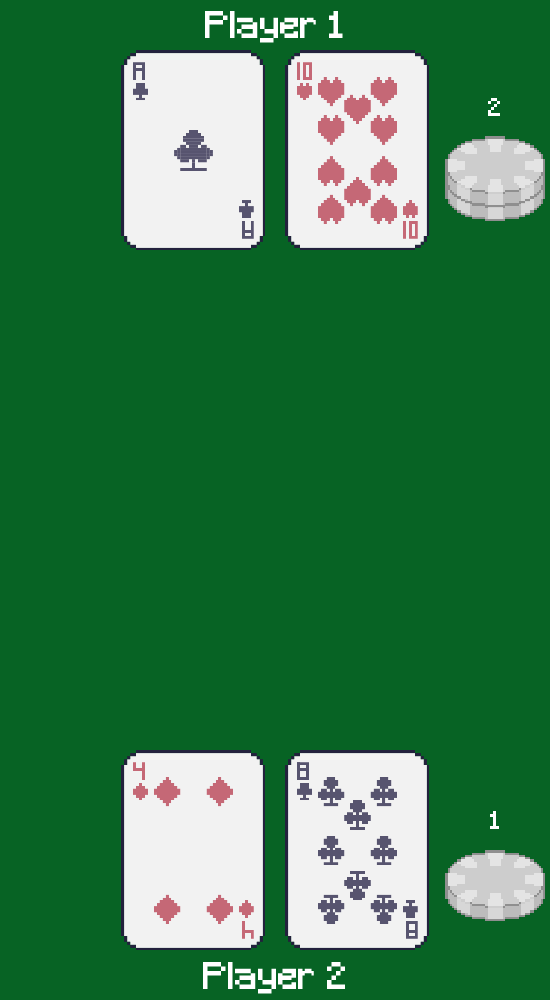


Simple Spread:


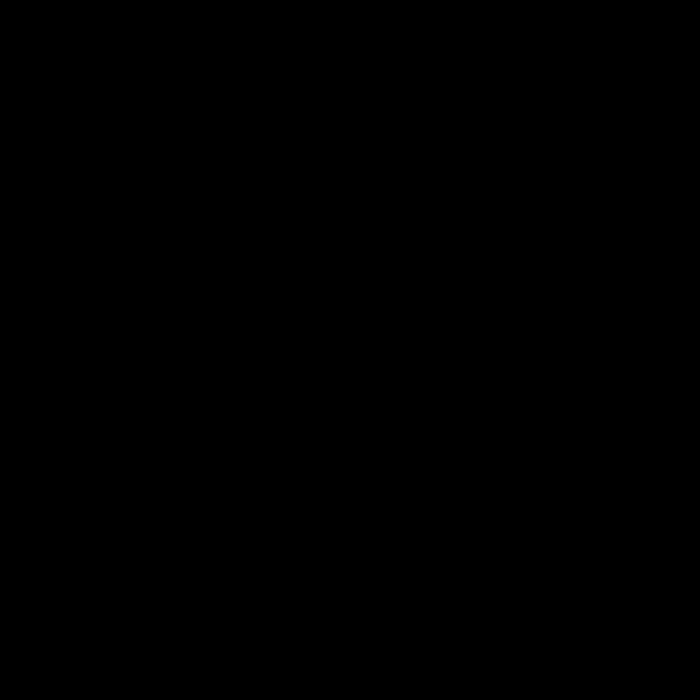


Simple:


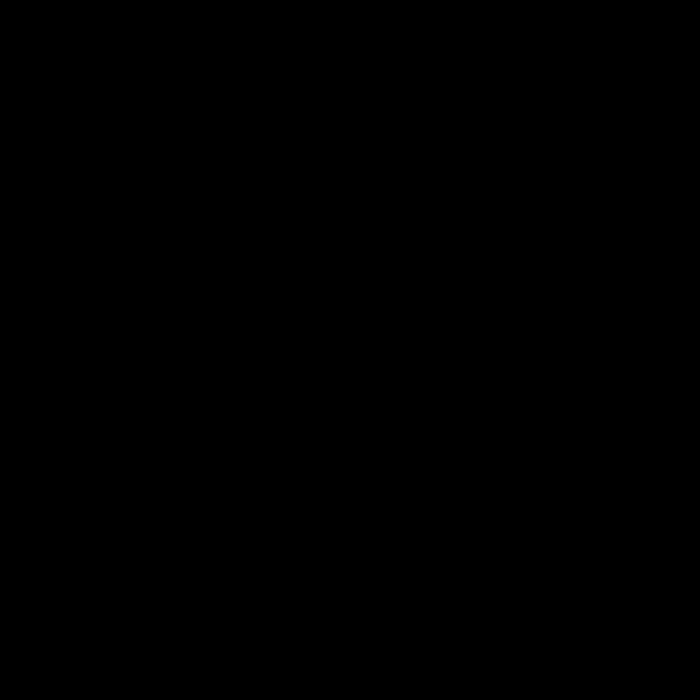

In [ ]:
!pip install pettingzoo[classic]

from PIL import Image
from pettingzoo.classic import texas_holdem_v4
from pettingzoo.mpe import simple_v2


# Works fine on classic environment...
env = texas_holdem_v4.env(render_mode="rgb_array")
env.reset()
frame=env.render()
img = Image.fromarray(frame, 'RGB')
print('Texas Hold\'em:')
img.show()
print('')

#But not fine on MPE environments
env = simple_spread_v2.env(N=3, local_ratio=0.5, max_cycles=25, continuous_actions=False, render_mode="rgb_array")
env.reset()
frame=env.render()
img = Image.fromarray(frame, 'RGB')
print('Simple Spread:')
img.show()
print('')

#Another one...
env = simple_v2.env(max_cycles=25, continuous_actions=False, render_mode="rgb_array")
env.reset()
frame=env.render()
img = Image.fromarray(frame, 'RGB')
print('Simple:')
img.show()